In [ ]:
# Validating models

In [ ]:
# Example

In [2]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

digits = load_digits()
X = digits.data
y = digits.target

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

In [4]:
y_pred = knn.predict(X)
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


In [5]:
# Validation sets

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(f'Training set: {X_train.shape}, test set: {X_test.shape}')

Training set: (1347, 64), test set: (450, 64)


In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

438 / 450 correct


In [7]:
# Accuracy score

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9733333333333334

This can also be computed directly from the model.score method:

In [11]:
knn.score(X_test, y_test)

0.9733333333333334

Using this, we can ask how this changes as we change the model parameters, in this case the number of neighbors:

In [12]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(f' Neighbors = {n_neighbors}, score = {knn.score(X_test, y_test)}')

 Neighbors = 1, score = 0.9733333333333334
 Neighbors = 5, score = 0.9777777777777777
 Neighbors = 10, score = 0.9777777777777777
 Neighbors = 20, score = 0.9644444444444444
 Neighbors = 30, score = 0.9533333333333334


In [13]:
# Cross validation

In [14]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=2)
cv.mean()

0.9616017302075308

In [15]:
print(f'Scores = {cv}')
print(f'Mean = {cv.mean()}')

Scores = [0.96329255 0.95991091]
Mean = 0.9616017302075308


In [16]:
# Model selection

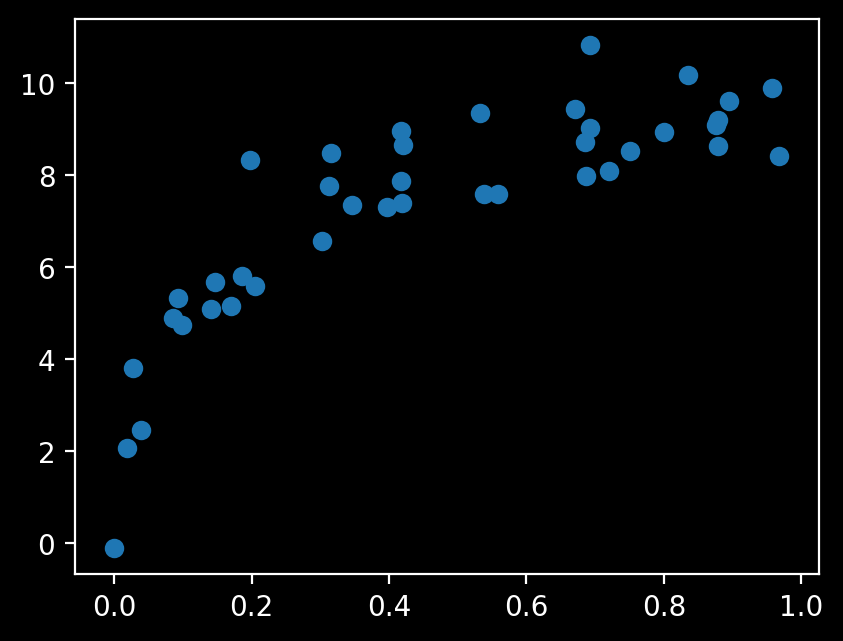

In [17]:
#Our 'target' function
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

# A routine to generate a sample dataset 
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    return X, y

import matplotlib.pyplot as plt
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

In [18]:
# Underfitting

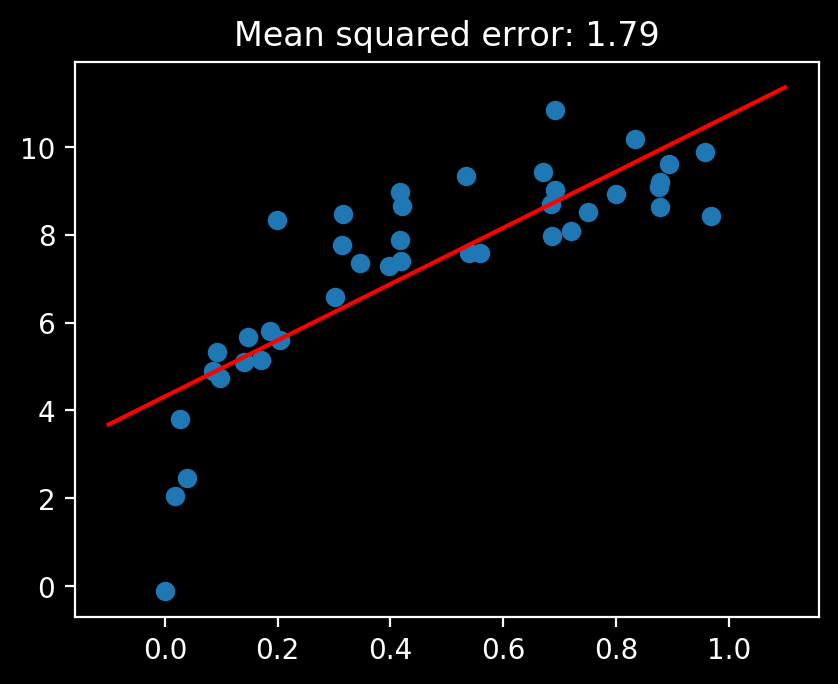

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
# Make a test set:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
y_test = model.predict(X_test)
# Plot the results:
plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test, c='r')
plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

# Adding degrees of freedom

Let's try to improve this by creating a more complicated model. We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs. Scikit-learn makes this easy with the PolynomialFeatures preprocessor, which can be pipelined with a linear regression.
Let's make a convenience routine to do this, and use it to fit a quadratic curve to the data.

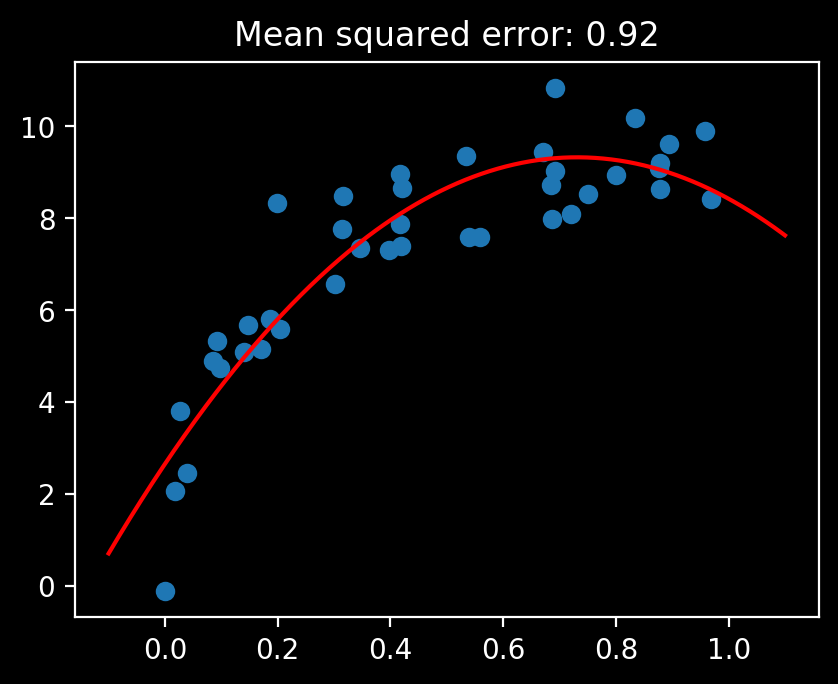

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)
# Plot the results:
plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test, c='r')
plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

In [21]:
# Overfitting model

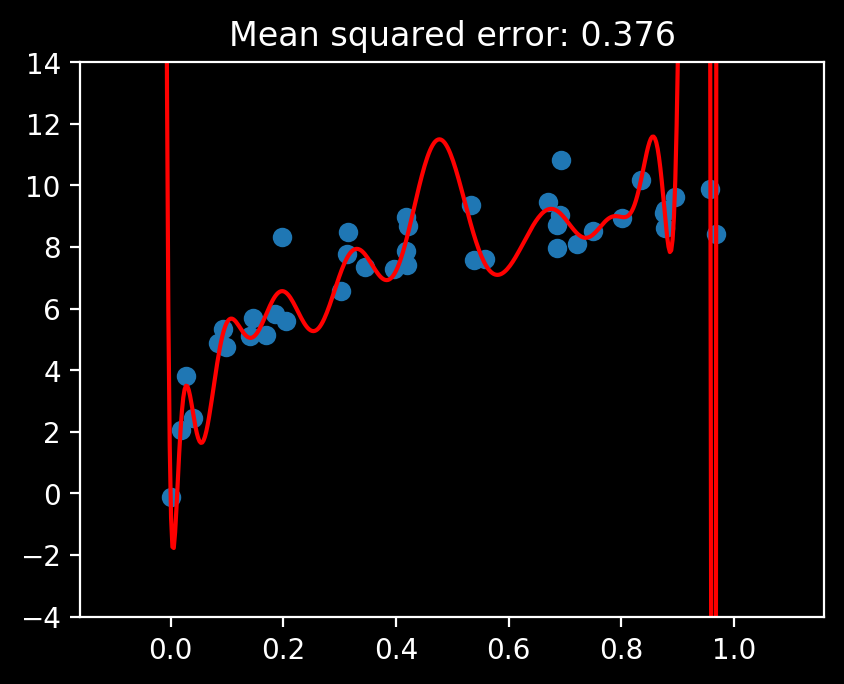

In [22]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)
plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test, c='r')
plt.title("Mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

In [23]:
# Bias variance trade off

In [24]:
from ipywidgets import interact

def plot_fit(degree=1, n_points=50):
    X, y = make_data(n_points, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    # Fit a polynomial regressor:
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)
    # Plot results:
    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test, c='r')
    plt.ylim(-4, 14)
    plt.title("Mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    plt.show()
    
interact(plot_fit, degree=[1, 2, 3, 4, 5, 10, 20, 30], n_points=[2, 10, 50, 100]);

interactive(children=(Dropdown(description='degree', options=(1, 2, 3, 4, 5, 10, 20, 30), value=1), Dropdown(d…

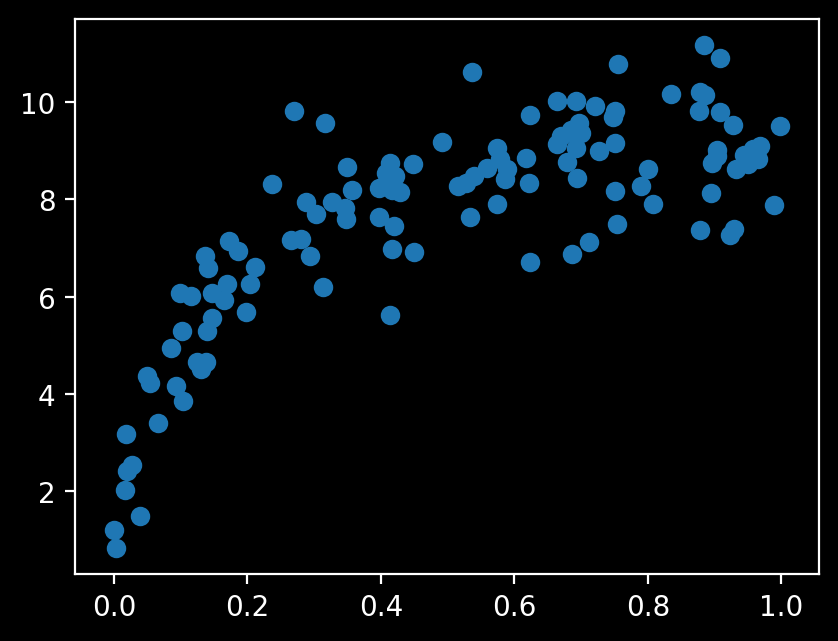

In [25]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [26]:
# Detecting underfitting and overfitting

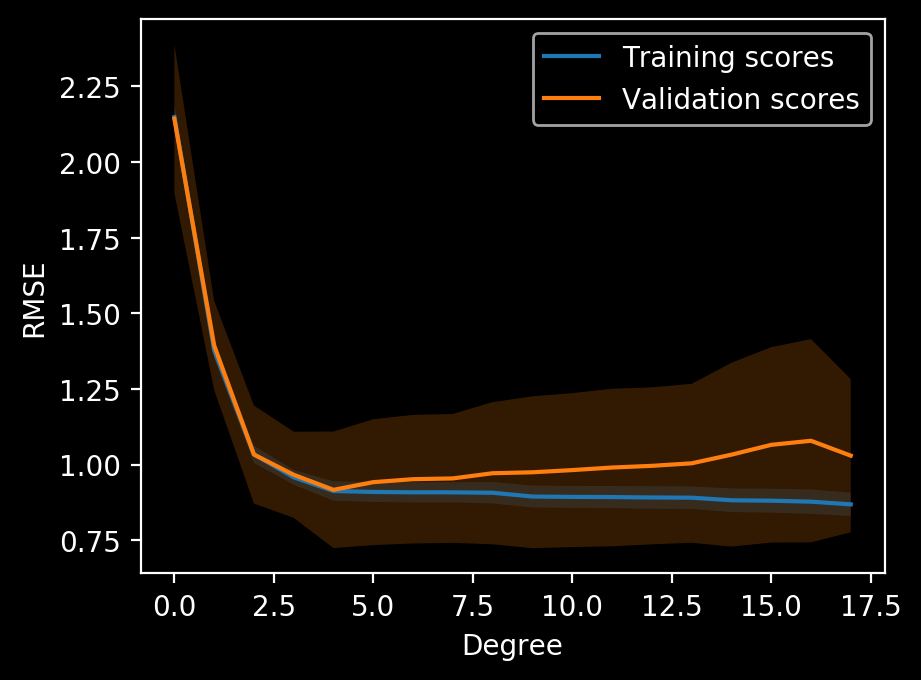

In [27]:
from sklearn.model_selection import validation_curve

# Calculates root-mean-square error for model's predictions:
def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

# Plots dataset's mean w/ standard deviation:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(
        x, mu - std, mu + std, edgecolor='none', 
        facecolor=lines[0].get_color(), alpha=0.2
    )

# We will try a range of degrees, up to 17:
degree = np.arange(0, 18)
val_train, val_test = validation_curve(
    PolynomialRegression(), X, y, param_name='polynomialfeatures__degree', 
    param_range=degree, cv=7, scoring=rms_error
)
plot_with_err(degree, val_train, label='Training scores')
plot_with_err(degree, val_test, label='Validation scores')
plt.xlabel('Degree'); plt.ylabel('RMSE')
plt.legend();

Notice the trend here, which is common for this type of plot.
For a small model complexity, the training error and validation error are very similar. This indicates that the model is underfitting the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a high-bias model.
As the model complexity grows, the training and validation scores diverge. This indicates that the model is overfitting the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a high-variance model.
Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is at around 5 terms.

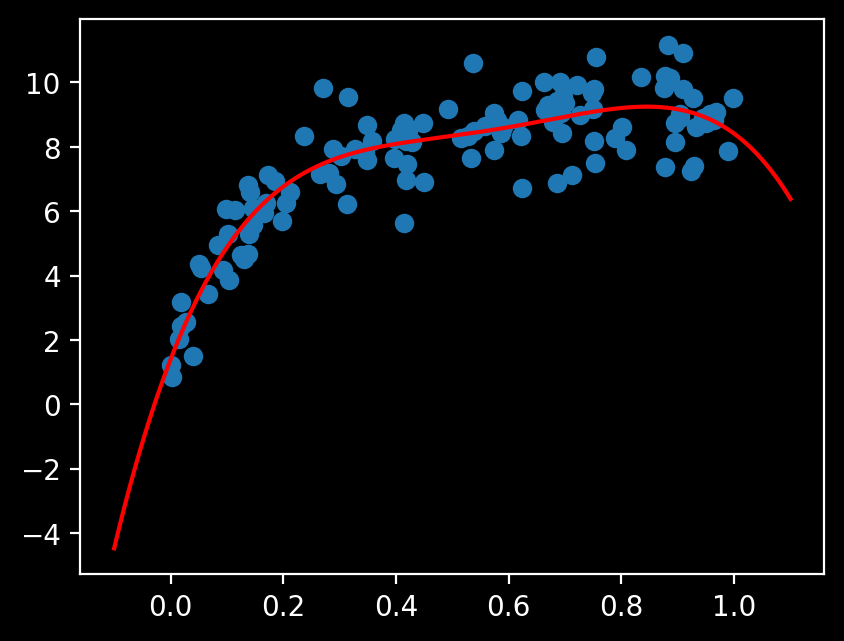

In [28]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test), c='r');